# 演示如何使用embedding嵌入。

它可以将高维度的数据转化为低维度的嵌入空间（embedding space），并保留原始数据的特征和语义信息，从而提高模型的效率和准确性。

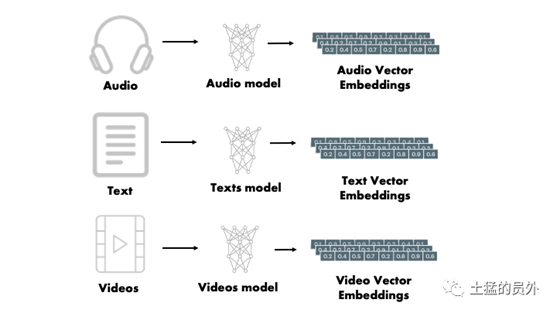

## 1.前提准备

### 1.1 使用代理访问openai

In [2]:
import os
import socket
import socks

socks.set_default_proxy(socks.SOCKS5, "127.0.0.1", 10808)
socket.socket = socks.socksocket

In [3]:
#安装所需的包
#!pip install tiktoken openai pandas matplotlib plotly scikit-learn numpy

## 2.使用embedding

In [4]:
from openai import OpenAI

client = OpenAI()

embedding_model = "text-embedding-ada-002"

res = client.embeddings.create(input="你好", model=embedding_model)


In [5]:
print(len(res.data[0].embedding))

1536


In [6]:
print(res.data[0].embedding)

[0.00020955623767804354, -0.006233605090528727, -0.002430693944916129, -0.029231708496809006, -0.04373347759246826, 0.013855271972715855, -0.022361116483807564, -0.00845513865351677, -0.01516093872487545, -0.019496256485581398, 0.03551919013261795, 0.0014633284881711006, 0.0046712420880794525, -0.002462384756654501, -0.008328375406563282, -0.016644073650240898, 0.03417549282312393, -0.015122909098863602, 0.018203267827630043, -0.020041340962052345, 8.027955118450336e-06, 0.0012715983903035522, 0.009203044697642326, 0.0008596163243055344, -0.007757938466966152, -0.007967098616063595, 0.00999531801789999, -0.018330030143260956, 0.007212854456156492, -0.008493168279528618, 0.01318342424929142, 0.01066716481000185, -0.02991623245179653, -0.0028648595325648785, 0.011979169212281704, -0.01343695167452097, -0.012384813278913498, -0.0018697645282372832, 0.020814599469304085, 0.004924769513309002, 0.016999011859297752, 0.010299550369381905, 0.00955798290669918, 0.010559416376054287, -0.01282214

In [8]:
import numpy as np

def embedding_text(text, model="text-embedding-ada-002"):
    res = client.embeddings.create(input=text, model=model)
    return res.data[0].embedding

def cos_sim(a, b):
    """计算余弦相似度"""
    cos = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos

In [9]:
man = embedding_text("man")
woman = embedding_text("woman")
stone = embedding_text("stone")
sand = embedding_text("sand")
rock = embedding_text("rock")

In [11]:
print(cos_sim(man,woman))
print(cos_sim(man,stone))
print(cos_sim(woman,stone))
print(cos_sim(sand,stone))
print(cos_sim(rock,stone))

0.9023238960333982
0.8206986300748024
0.8334640845906819
0.8642077099181474
0.9069638451462199


## 3.使用embedding进行文本分类

In [20]:
text1 = embedding_text("外卖服务实在是太棒了,服务时间短,质量也非常好,菜品也很丰富,给我们带来了许多惊喜。 ")
pos = embedding_text("好评")
neg = embedding_text("差评")

print(cos_sim(text1,pos))
print(cos_sim(text1,neg))


0.815319424453933
0.7683225340749488


## 4.使用tiktoken用于分词和token计算

tiktoken是OpenAI开发的一种BPE分词器。BPE分词器的工作原理是通过迭代地将频繁共现的字节对合并成一个新的词元，从而动态地构建一个词汇表。这个过程是数据驱动的，可以根据语料库中的数据自适应地生成词汇表，不需要预先定义固定的词汇表。

给定一段文本字符串（例如，"tiktoken is great!"）和一种编码方式（例如，"cl100k_base"），分词器可以将文本字符串切分成一系列的token（例如，["t", "ik", "token", " is", " great", "!"]）。

将文本字符串切分成token非常有用，因为GPT模型看到的文本就是以token的形式呈现的。知道一段文本字符串中有多少个token可以告诉你（a）这个字符串是否对于文本模型来说太长了而无法处理，以及（b）一个OpenAI API调用的费用是多少（因为使用量是按照token计价的）。

In [22]:
#!pip install --upgrade tiktoken

### 4.1 编码方式

编码方式规定了如何将文本转换成token。不同的模型使用不同的编码方式。

tiktoken支持OpenAI模型使用的三种编码方式：

| 编码名称    | OpenAI模型                            |
|------------|-------------------------------------|
| cl100k_base| gpt-4, gpt-3.5-turbo, text-embedding-ada-002 |
| p50k_base  | Codex模型, text-davinci-002, text-davinci-003 |
| r50k_base (或 gpt2)| 像 davinci 这样的GPT-3模型          |


你可以使用 tiktoken.encoding_for_model() 获取一个模型的编码方式，如下所示：

encoding = tiktoken.encoding_for_model('gpt-3.5-turbo')

In [26]:
import tiktoken

encoding1 = tiktoken.get_encoding("cl100k_base")
encoding2 = tiktoken.encoding_for_model("gpt-3.5-turbo")

print(encoding1,encoding2,encoding1==encoding2)


<Encoding 'cl100k_base'> <Encoding 'cl100k_base'> True


### 4.2 将文本转换为token

In [27]:
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
encoding.encode("tiktoken is great！！!")

[83, 1609, 5963, 374, 2294, 32351, 0]

### 4.3 将token转换为文本

In [29]:
encoding.decode([83, 1609, 5963, 374, 2294, 0])

'tiktoken is great!'

### 4.4 获取token数量

In [28]:

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """返回文本字符串中的Token数量"""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

num_tokens_from_string("tiktoken is great!", "cl100k_base")


6

### 4.5 估计GPT所消耗的token梳理

ChatGPT模型，如gpt-3.5-turbo和gpt-4，与旧的完成模型一样使用token，但由于其基于消息的格式，很难准确计算对话中将使用多少个token。

下面是一个示例函数，用于计算传递给gpt-3.5-turbo或gpt-4的消息中的token数量。

请注意，从消息中计算token的确切方式可能因模型而异。请将下面函数中的计数视为估计值，并非永恒保证。

特别地，在使用可选功能输入(input)的请求上方会消耗额外的token。

In [31]:
# 定义函数 num_tokens_from_messages，该函数返回由一组消息所使用的token数。
def num_tokens_from_messages(messages, model="gpt-3.5-turbo"):
    """Return the number of tokens used by a list of messages."""
    # 尝试获取模型的编码
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        # 如果模型没有找到，使用 cl100k_base 编码并给出警告
        print("Warning: model not found. Using cl100k_base encoding.")
        encoding = tiktoken.get_encoding("cl100k_base")
    # 针对不同的模型设置token数量
    if model in {
        "gpt-3.5-turbo-0613",
        "gpt-3.5-turbo-16k-0613",
        "gpt-4-0314",
        "gpt-4-32k-0314",
        "gpt-4-0613",
        "gpt-4-32k-0613",
        }:
        tokens_per_message = 3
        tokens_per_name = 1
    elif model == "gpt-3.5-turbo-0301":
        tokens_per_message = 4  # 每条消息遵循 {role/name}\n{content}\n 格式
        tokens_per_name = -1  # 如果有名字，角色会被省略
    elif "gpt-3.5-turbo" in model:
        # 对于 gpt-3.5-turbo 模型可能会有更新，此处返回假设为 gpt-3.5-turbo-0613 的token数量，并给出警告
        print("Warning: gpt-3.5-turbo may update over time. Returning num tokens assuming gpt-3.5-turbo-0613.")
        return num_tokens_from_messages(messages, model="gpt-3.5-turbo-0613")
    elif "gpt-4" in model:
        # 对于 gpt-4 模型可能会有更新，此处返回假设为 gpt-4-0613 的token数量，并给出警告
        print("Warning: gpt-4 may update over time. Returning num tokens assuming gpt-4-0613.")
        return num_tokens_from_messages(messages, model="gpt-4-0613")
    elif model in {
        "davinci",
        "curie",
        "babbage",
        "ada"
        }:
        print("Warning: gpt-3 related model is used. Returning num tokens assuming gpt2.")
        encoding = tiktoken.get_encoding("gpt2")
        num_tokens = 0
        # only calc the content
        for message in messages:
            for key, value in message.items():
                if key == "content":
                    num_tokens += len(encoding.encode(value))
        return num_tokens
    else:
        # 对于没有实现的模型，抛出未实现错误
        raise NotImplementedError(
            f"""num_tokens_from_messages() is not implemented for model {model}. See https://github.com/openai/openai-python/blob/main/chatml.md for information on how messages are converted to tokens."""
        )
    num_tokens = 0
    # 计算每条消息的token数
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3  # 每条回复都以助手为首
    return num_tokens

In [35]:

# OpenAI Python SDK v1.0 更新后的使用方式
from openai import OpenAI
client = OpenAI()


example_messages = [
    {
        "role": "system",
        "content": "You are a helpful, pattern-following assistant that translates corporate jargon into plain English.",
    },
    {
        "role": "system",
        "name": "example_user",
        "content": "New synergies will help drive top-line growth.",
    },
    {
        "role": "system",
        "name": "example_assistant",
        "content": "Things working well together will increase revenue.",
    },
    {
        "role": "system",
        "name": "example_user",
        "content": "Let's circle back when we have more bandwidth to touch base on opportunities for increased leverage.",
    },
    {
        "role": "system",
        "name": "example_assistant",
        "content": "Let's talk later when we're less busy about how to do better.",
    },
    {
        "role": "user",
        "content": "This late pivot means we don't have time to boil the ocean for the client deliverable.",
    },
]

for model in [
    "gpt-3.5-turbo-0613",
    "gpt-3.5-turbo",
    #"gpt-4-0613",
    #"gpt-4",
    ]:
    print(model)
    # example token count from the function defined above
    print(f"{num_tokens_from_messages(example_messages, model)} prompt tokens counted by num_tokens_from_messages().")
    # example token count from the OpenAI API
    # OpenAI Python SDK v1.0 更新后的使用方式
    completion = client.chat.completions.create(
        model=model,
        messages=example_messages,
        temperature=0,
        max_tokens=1,  # we're only counting input tokens here, so let's not waste tokens on the output
    )
    print(f'{completion.usage.prompt_tokens} prompt tokens counted by the OpenAI API.')
    print()

gpt-3.5-turbo-0613
129 prompt tokens counted by num_tokens_from_messages().
129 prompt tokens counted by the OpenAI API.

gpt-3.5-turbo
129 prompt tokens counted by num_tokens_from_messages().
129 prompt tokens counted by the OpenAI API.

